# XAI CODE DEMO

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/explainable-ml-example-notebooks/saliency_maps.ipynb)

# Saliency Maps 🖼️

Pixel attribution highlights the pixels relevant to an image classification by a neural network. Visualizations via the vanilla gradient are also known as saliency maps.

### How does it work?
Calculate the gradient of the loss function for the class of interest with respect to the input pixels

Process:
1. Perform a forward pass of image of interest
2. Compute the gradient of the class score of interest with respect to the input pixels (set all other classes to zero)
3. Visualize the gradients (show absolute values or highlight negative and positive contributions)


In [35]:
!pip install numpy==1.25.2 matplotlib==3.7.1 tensorflow==2.14.1

In [ ]:
# Basic
import numpy as np
import matplotlib.pyplot as plt

# Model Utils
import tensorflow as tf

# Data Utils
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from keras.utils import get_file
import json

#### Tensorflow Terminology: gradient tape

A **gradient tape** is a TensorFlow mechanism for automatic differentiation. We use it to record operations for which we want to compute gradients, typically within the context of training a neural network. When we perform operations inside a tf.GradientTape() context, TensorFlow keeps track of all the computations that occur on tensors that are "watched" by the tape.

Here gradient tape is used to compute the gradients of the model's predictions with respect to the input image tensor.

In [ ]:
# Function to generate a saliency map for an input image based on a given model

def generate_saliency_map(model, img):
    # Convert the input image to a TensorFlow variable
    x = tf.Variable(img)

    # Add an extra dimension to the image tensor to match the model's input shape
    x = tf.expand_dims(x, axis=0)

    # Preprocess the image according to ResNet50 requirements
    x = tf.keras.applications.resnet50.preprocess_input(x)

    # Create a gradient tape context to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor to calculate gradients
        tape.watch(x)

        # Forward pass: get model predictions for the input image
        preds = model(x)

        # Find the index of the highest predicted class probability
        top_pred_index = tf.argmax(preds[0])

    # Calculate the gradients of the top prediction with respect to the input image
    grads = tape.gradient(preds, x)

    # Compute the saliency map by taking the maximum absolute gradient across color channels
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    # Return the saliency map and the index of the top predicted class as a numpy array
    return saliency, top_pred_index.numpy()


We will load a pre-trained model, [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50)

and a test image from the [ImageNetV2](https://www.tensorflow.org/datasets/catalog/imagenet_v2) dataset



In [41]:
index = 1 #Change the index to get a different image

# Load ResNet50 pre-trained model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

# Load dataset from ImageNetV2
dataset, info = tfds.load('imagenet_v2', with_info=True, split="test[:5%]", as_supervised=True)
for img, label in dataset.take(index):
    img = tf.image.resize(img, (224, 224))
    img = img.numpy().astype(np.float32)

# Download the ImageNet class index file
class_index_path = get_file('imagenet_class_index.json', 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')

# Load ImageNet class labels
with open(class_index_path) as f:
    class_idx = json.load(f)

In [42]:
# Generate saliency map
saliency_map, top_pred_index = generate_saliency_map(model, img)

# Map the index to class label
predicted_class = class_idx[str(top_pred_index)][1]

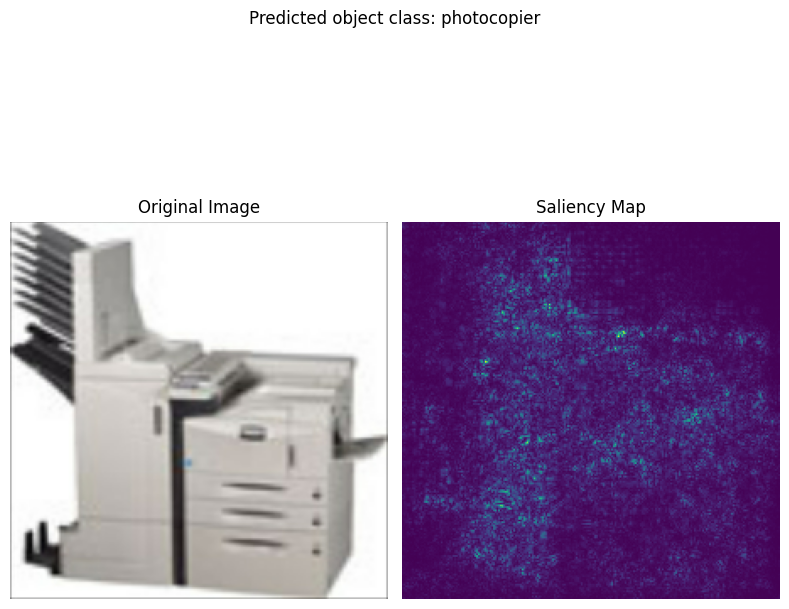

In [43]:
# Display the original image
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.tight_layout()

# Display the saliency map
plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap='viridis')
plt.title("Saliency Map")
plt.suptitle(f"Predicted object class: {predicted_class}")
plt.axis('off')
plt.tight_layout()

plt.show()